In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.svm import SVC

___Chapter 8: Problem 8___

In the lab, a classification tree was applied to the Carseats data set after converting Sales into a qualitative response variable. Now we will seek to predict Sales using regression trees and related approaches, treating the response as a quantitative variable.

(a) Split the data set into a training set and a test set.

In [2]:
carseats_df = pd.read_csv('Carseats.csv')
carseats_df

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...
395,12.57,138,108,17,203,128,Good,33,14,Yes,Yes
396,6.14,139,23,3,37,120,Medium,55,11,No,Yes
397,7.41,162,26,12,368,159,Medium,40,18,Yes,Yes
398,5.94,100,79,7,284,95,Bad,50,12,Yes,Yes


In [3]:
features = carseats_df.drop('Sales', axis=1)
target_sales = carseats_df['Sales']

categorical_columns = features.select_dtypes(include='object').columns
features_encoded = pd.get_dummies(features, columns=categorical_columns, drop_first=True)

x_train, x_test, y_train, y_test = train_test_split(
    features_encoded, 
    target_sales, 
    test_size=0.2, 
    random_state=42
)

print(f"Training features shape: {x_train.shape}")
print(f"Test features shape: {x_test.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Test target shape: {y_test.shape}")

Training features shape: (320, 11)
Test features shape: (80, 11)
Training target shape: (320,)
Test target shape: (80,)


(b) Fit a regression tree to the training set. Plot the tree, and interpret the results. What test MSE do you obtain?

Test MSE: 6.1789


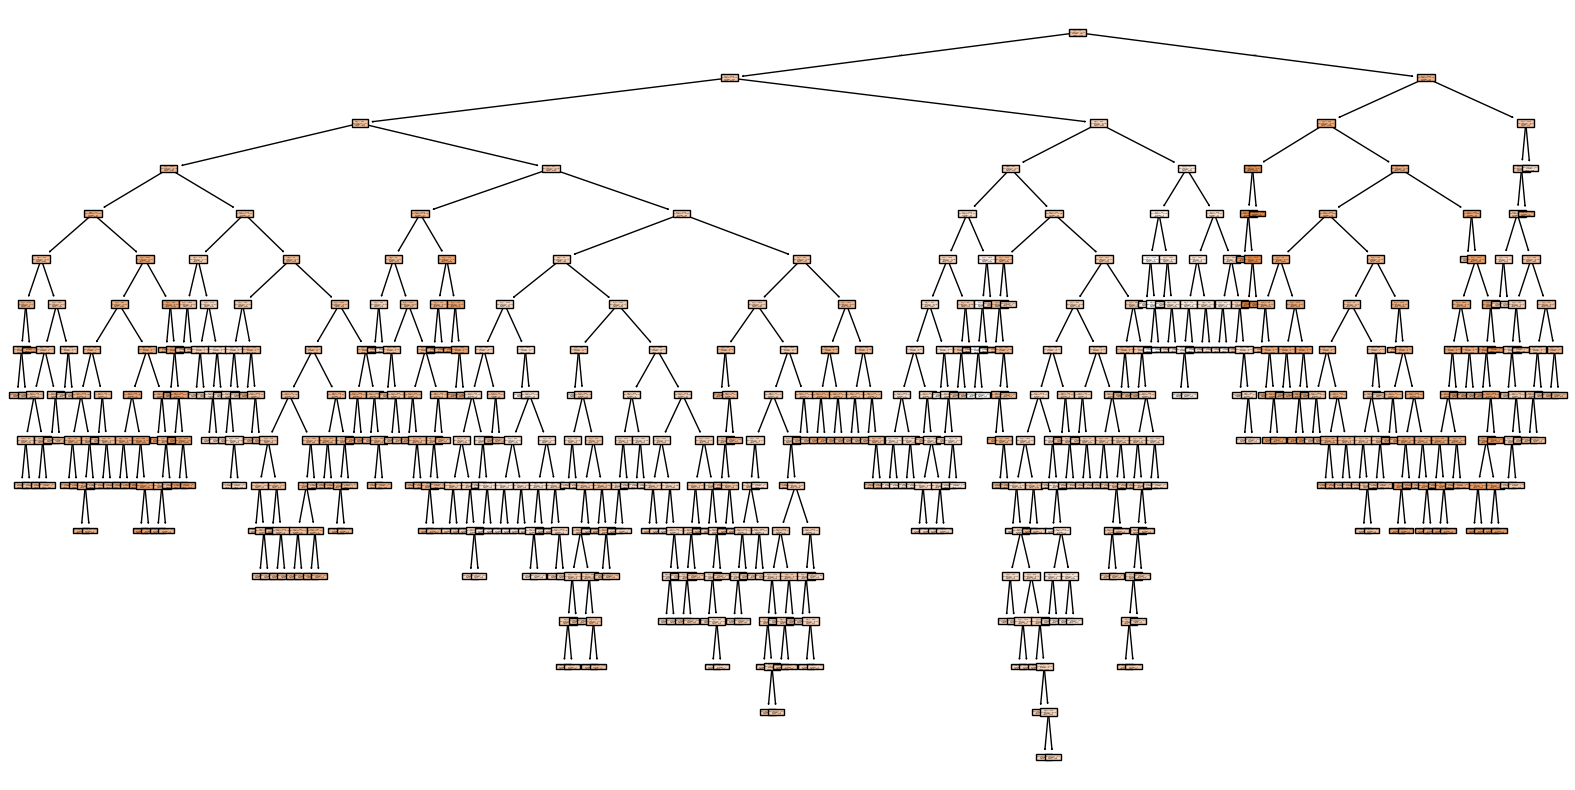


Tree depth: 16
Number of leaves: 320
Number of features used: 11


In [4]:
regression_tree = DecisionTreeRegressor(random_state=42)
regression_tree.fit(x_train, y_train)

y_pred = regression_tree.predict(x_test)

test_mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {test_mse:.4f}")

plt.figure(figsize=(20, 10))
plot_tree(regression_tree, filled=True)
plt.show()

# Display tree information
print(f"\nTree depth: {regression_tree.get_depth()}")
print(f"Number of leaves: {regression_tree.get_n_leaves()}")
print(f"Number of features used: {regression_tree.n_features_in_}")

(c) Use cross-validation in order to determine the optimal level of tree complexity. Does pruning the tree improve the test MSE?

In [5]:
path = regression_tree.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas = path.ccp_alphas
impurities = path.impurities

ccp_alphas = ccp_alphas[:-1]

alpha_scores = []

for ccp_alpha in ccp_alphas:
    tree_model = DecisionTreeRegressor(random_state=42, ccp_alpha=ccp_alpha)
    cv_scores = cross_val_score(
        tree_model, 
        x_train, 
        y_train, 
        cv=5, 
        scoring='neg_mean_squared_error'
    )
    alpha_scores.append(-cv_scores.mean())

optimal_idx = np.argmin(alpha_scores)
optimal_alpha = ccp_alphas[optimal_idx]
optimal_cv_mse = alpha_scores[optimal_idx]

pruned_tree = DecisionTreeRegressor(random_state=42, ccp_alpha=optimal_alpha)
pruned_tree.fit(x_train, y_train)

y_pred_pruned = pruned_tree.predict(x_test)
test_mse_pruned = mean_squared_error(y_test, y_pred_pruned)

print(f"Pruned Tree   - Test MSE: {test_mse_pruned:.4f}")
print(f"Improvement: {test_mse - test_mse_pruned:.4f} {'(Better)' if test_mse_pruned < test_mse else '(Worse)'}")
print(f"Pruned Tree   - Depth: {pruned_tree.get_depth()}, Leaves: {pruned_tree.get_n_leaves()}")

print()

print("5-fold cross validation selects a pruned tree model that achieves test MSE of 5.3588, an improvement on the unpruned model (0.8201 better)")

Pruned Tree   - Test MSE: 5.3588
Improvement: 0.8201 (Better)
Pruned Tree   - Depth: 10, Leaves: 60

5-fold cross validation selects a pruned tree model that achieves test MSE of 5.3588, an improvement on the unpruned model (0.8201 better)


(d) Use the bagging approach in order to analyze this data. What test MSE do you obtain? Use the feature_importance_ values to determine which variables are most important.

In [6]:
bag_model = BaggingRegressor(
    estimator=DecisionTreeRegressor(),
    n_estimators=500,
    random_state=42,
    n_jobs=-1
)

bag_model.fit(x_train, y_train)
y_pred = bag_model.predict(x_test)
test_mse = mean_squared_error(y_test, y_pred)
print("Test MSE (Bagging):", test_mse)
print()
imp = np.array([ tree.feature_importances_ for tree in bag_model.estimators_])
avg_imp = np.mean(imp, axis=0)
print(avg_imp)
print()
feature_imp = pd.Series(avg_imp, index=x_train.columns)
print(feature_imp)

Test MSE (Bagging): 3.0667348011850004

[0.0947791  0.05291081 0.08230098 0.04030311 0.31464059 0.11761164
 0.02973485 0.19728832 0.05803206 0.00687469 0.00552385]

CompPrice           0.094779
Income              0.052911
Advertising         0.082301
Population          0.040303
Price               0.314641
Age                 0.117612
Education           0.029735
ShelveLoc_Good      0.197288
ShelveLoc_Medium    0.058032
Urban_Yes           0.006875
US_Yes              0.005524
dtype: float64


(e) Use random forests to analyze this data. What test MSE do you obtain? Use the feature_importance_ values to determine which variables are most important. Describe the effect of m, the number of variables considered at each split, on the error rate obtained.

In [7]:
random_forest = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
random_forest.fit(x_train, y_train)
y_pred_rf = random_forest.predict(x_test)
test_mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"Random Forest - Test MSE:  {test_mse_rf:.4f}")

print()

feature_importance = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': random_forest.feature_importances_
}).sort_values('Importance', ascending=False)

print(feature_importance.head(10).to_string(index=False))

print()

print("EFFECT OF m ON TEST MSE")
m_values = [1, 2, 3, 4, 5, 6, x_train.shape[1]//3, x_train.shape[1]//2, x_train.shape[1]]
m_results = []

for m in m_values:
    rf_model = RandomForestRegressor(
        n_estimators=500, 
        max_features=m, 
        random_state=42, 
        n_jobs=-1
    )
    rf_model.fit(x_train, y_train)
    
    y_pred = rf_model.predict(x_test)
    mse = mean_squared_error(y_test, y_pred)
    
    m_results.append({
        'm': m,
        'Test_MSE': mse
    })
    
    print(f"m = {m:2d} | Test MSE: {mse:.4f}")

m_results_df = pd.DataFrame(m_results)
optimal_m = m_results_df.loc[m_results_df['Test_MSE'].idxmin()]

print(f"Optimal m: {int(optimal_m['m'])}")
print(f"Best Test MSE: {optimal_m['Test_MSE']:.4f}")

print()

print("Changing the m value result in better test MSEs")

Random Forest - Test MSE:  3.0509

         Feature  Importance
           Price    0.314443
  ShelveLoc_Good    0.197284
             Age    0.117424
       CompPrice    0.094673
     Advertising    0.082258
ShelveLoc_Medium    0.058050
          Income    0.052602
      Population    0.040865
       Education    0.030047
       Urban_Yes    0.006692

EFFECT OF m ON TEST MSE
m =  1 | Test MSE: 5.5657
m =  2 | Test MSE: 4.4419
m =  3 | Test MSE: 3.7528
m =  4 | Test MSE: 3.4433
m =  5 | Test MSE: 3.2766
m =  6 | Test MSE: 3.2302
m =  3 | Test MSE: 3.7528
m =  5 | Test MSE: 3.2766
m = 11 | Test MSE: 3.0509
Optimal m: 11
Best Test MSE: 3.0509

Changing the m value result in better test MSEs


___Chapter 9: Problem 8___

This problem involves the OJ data set which is part of the ISLP package.

(a) Create a training set containing a random sample of 800 observations, and a test set containing the remaining observations.

In [8]:
oj_df = pd.read_csv('OJ.csv')
oj_df

,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
0,CH,237,1,1.75,1.99,0.00,0.00,0,0,0.500000,1.99,1.75,0.24,No,0.000000,0.000000,0.24,1
1,CH,239,1,1.75,1.99,0.00,0.30,0,1,0.600000,1.69,1.75,-0.06,No,0.150754,0.000000,0.24,1
2,CH,245,1,1.86,2.09,0.17,0.00,0,0,0.680000,2.09,1.69,0.40,No,0.000000,0.091398,0.23,1
3,MM,227,1,1.69,1.69,0.00,0.00,0,0,0.400000,1.69,1.69,0.00,No,0.000000,0.000000,0.00,1
4,CH,228,7,1.69,1.69,0.00,0.00,0,0,0.956535,1.69,1.69,0.00,Yes,0.000000,0.000000,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065,CH,252,7,1.86,2.09,0.10,0.00,0,0,0.587822,2.09,1.76,0.33,Yes,0.000000,0.053763,0.23,0
1066,CH,256,7,1.86,2.18,0.00,0.00,0,0,0.670258,2.18,1.86,0.32,Yes,0.000000,0.000000,0.32,0
1067,MM,257,7,1.86,2.18,0.00,0.00,0,0,0.736206,2.18,1.86,0.32,Yes,0.000000,0.000000,0.32,0
1068,CH,261,7,1.86,2.13,0.00,0.24,0,0,0.588965,1.89,1.86,0.03,Yes,0.112676,0.000000,0.27,0


In [9]:
oj_df['Store7'] = np.where(oj_df['Store7'] == 'Yes', 1, 0)

x_train, x_test = train_test_split(oj_df, train_size=800, random_state=42)
print(x_train.shape)
print(x_test.shape)

(800, 18)
(270, 18)


(b) Fit a support vector classifier to the training data using
C = 0.01, with Purchase as the response and the other variables
as predictors. How many support points are there?

In [10]:
y_train = x_train['Purchase']
x_train = x_train.drop('Purchase', axis=1)

y_train = y_train.map({'CH': 1, 'MM': 0})

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_train)
print(x_scaled)

[[ 1.06107074 -0.42067204  1.20787721 ...  0.42049414 -1.11655046
   0.96428077]
 [ 0.99732362 -0.8526844  -0.06074761 ... -0.41593246  0.94874518
   0.26552659]
 [-0.66010138 -1.28469677 -0.06074761 ... -0.41593246  0.10385151
  -0.43322759]
 ...
 [ 0.42359958 -1.28469677 -1.03661286 ... -0.41593246  0.10385151
  -0.43322759]
 [-0.85134273 -1.28469677 -0.06074761 ... -0.41593246 -0.83491923
  -0.43322759]
 [ 1.25231209  1.30737741 -0.06074761 ...  3.79005277  0.47935981
  -1.13198178]]


In [11]:
svc = SVC(C=0.01)
svc.fit(x_scaled, y_train)

,C,0.01
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [12]:
print("There are", len(svc.support_), "support points")
print("Support Vectors:", svc.n_support_)

There are 618 support points
Support Vectors: [306 312]


(c) What are the training and test error rates?

In [13]:
y_pred_train = svc.predict(x_scaled)

y_test = x_test['Purchase']
x_test = x_test.drop('Purchase', axis=1)
y_test = y_test.map({'CH': 1, 'MM': 0})
x_test_scaled = scaler.fit_transform(x_test)
y_test_pred = svc.predict(x_test_scaled)

train_error = 1 - accuracy_score(y_train, y_pred_train)
test_error = 1 - accuracy_score(y_test, y_test_pred)
print("Training Error:", train_error)
print("Test Error:", test_error)

Training Error: 0.38249999999999995
Test Error: 0.4111111111111111


(d) Use cross-validation to select an optimal C. Consider values in
the range 0.01 to 10.

In [14]:
c_values = [0.01, 0.1, 0.5, 1, 2, 5, 10]
cv_scores = []

for c in c_values:
  svc = SVC(C=c)
  scores = cross_val_score(svc, x_scaled, y_train, cv=5)
  cv_scores.append(np.mean(scores))

print(cv_scores)

print()

optimal_c = c_values[np.argmax(cv_scores)]
print("Optimal C =", optimal_c)

[np.float64(0.6175), np.float64(0.8162499999999999), np.float64(0.8237500000000001), np.float64(0.8212499999999998), np.float64(0.81875), np.float64(0.8125), np.float64(0.8125)]

Optimal C = 0.5


(e) Compute the training and test error rates using this new value
for C.

In [15]:
accuracy_svc = SVC(C=optimal_c)
accuracy_svc.fit(x_scaled, y_train)
y_pred_train = accuracy_svc.predict(x_scaled)
y_test_pred = accuracy_svc.predict(x_test_scaled)

train_error = 1 - accuracy_score(y_train, y_pred_train)
test_error = 1 - accuracy_score(y_test, y_test_pred)

(f) Repeat parts (b) through (e) using a support vector machine with a radial kernel. Use the default value for gamma.

In [16]:
svc_radial_k = SVC(C=0.01, kernel='rbf')
svc_radial_k.fit(x_scaled, y_train)
print("Support Points:", len(svc_radial_k.support_))
print("Support Vectors:", svc_radial_k.n_support_)

Support Points: 618
Support Vectors: [306 312]


In [17]:
y_pred_train = svc_radial_k.predict(x_scaled)
y_pred_test = svc_radial_k.predict(x_test_scaled)
train_error = 1 - accuracy_score(y_train, y_pred_train)
test_error = 1 - accuracy_score(y_test, y_pred_test)
print("Training Error:", train_error)
print("Test Error:", test_error)

Training Error: 0.38249999999999995
Test Error: 0.4111111111111111


In [18]:
c_values = [0.01, 0.1, 0.5, 1, 2, 5, 10]
cv_scores = []

for c in c_values:
  svc = SVC(C=c, kernel='rbf')
  scores = cross_val_score(svc, x_scaled, y_train, cv=5)
  cv_scores.append(np.mean(scores))
print(cv_scores)

print()

optimal_c = c_values[np.argmax(cv_scores)]
print("Optimal C =", optimal_c)

[np.float64(0.6175), np.float64(0.8162499999999999), np.float64(0.8237500000000001), np.float64(0.8212499999999998), np.float64(0.81875), np.float64(0.8125), np.float64(0.8125)]

Optimal C = 0.5


In [19]:
accuracy_svc = SVC(C=optimal_c, kernel='rbf')
accuracy_svc.fit(x_scaled, y_train)
y_pred_train = accuracy_svc.predict(x_scaled)
y_test_pred = accuracy_svc.predict(x_test_scaled)

train_error = 1 - accuracy_score(y_train, y_pred_train)
test_error = 1 - accuracy_score(y_test, y_test_pred)
print("Training Error:", train_error)
print("Test Error:", test_error)

Training Error: 0.14749999999999996
Test Error: 0.1962962962962963


In [20]:
accuracy_svc

,C,0.5
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


(g) Repeat parts (b) through (e) using a support vector machine with a polynomial kernel. Set degree = 2.

In [21]:
svc_poly = SVC(C=0.01, kernel='poly', degree=2)
svc_poly.fit(x_scaled, y_train)
print("Support Points:", len(svc_poly.support_))
print("Support Vectors:", svc_poly.n_support_)

Support Points: 617
Support Vectors: [306 311]


In [22]:
y_pred_train = svc_poly.predict(x_scaled)
y_pred_test = svc_poly.predict(x_test_scaled)
train_error = 1 - accuracy_score(y_train, y_pred_train)
test_error = 1 - accuracy_score(y_test, y_pred_test)
print("Training Error:", train_error)
print("Test Error:", test_error)

Training Error: 0.36750000000000005
Test Error: 0.40740740740740744


In [23]:
c_values = [0.01, 0.1, 0.5, 1, 2, 5, 10]
cv_scores = []

for c in c_values:
  svc_poly = SVC(C=c, kernel='poly', degree=2)
  scores = cross_val_score(svc_poly, x_scaled, y_train, cv=5)
  cv_scores.append(np.mean(scores))
print(cv_scores)

print()

optimal_c = c_values[np.argmax(cv_scores)]
print("Optimal C =", optimal_c)

[np.float64(0.6175), np.float64(0.6762499999999999), np.float64(0.72875), np.float64(0.7425), np.float64(0.7450000000000001), np.float64(0.7537499999999999), np.float64(0.77125)]

Optimal C = 10


In [24]:
accuracy_svc = SVC(C=optimal_c, kernel='poly', degree=2)
accuracy_svc.fit(x_scaled, y_train)
y_pred_train = accuracy_svc.predict(x_scaled)
y_test_pred = accuracy_svc.predict(x_test_scaled)

train_error = 1 - accuracy_score(y_train, y_pred_train)
test_error = 1 - accuracy_score(y_test, y_test_pred)
print("Training Error:", train_error)
print("Test Error:", test_error)

Training Error: 0.19625000000000004
Test Error: 0.24814814814814812


(h) Overall, which approach seems to give the best results on this
data?



SVC (radial kernel and no kernel) gave a better test error than using a polynomial kernel having degree = 2